In [46]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import glob, re

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../../src')
from m3_learning.RHEED.Analysis import detect_peaks, process_rheed_data, process_curves, select_range
from m3_learning.RHEED.Fitting import fit_exp_function, normalize_and_extract_amplitude, de_normalize_and_assemble, fit_curves
from m3_learning.viz.layout import layout_fig
from m3_learning.RHEED.Viz import Viz

from scipy.fftpack import fft, ifft
# Filter signals (band-pass filters)
def bandpass_filter(signal_fft, freq, fs, lowcut, highcut):
    f = np.fft.fftfreq(len(signal_fft), 1/fs)
    filter_mask = np.logical_and(freq >= lowcut, freq <= highcut)
    filter_mask = np.logical_or(filter_mask, np.logical_and(freq <= -lowcut, freq >= -highcut))
    filtered_fft = signal_fft * filter_mask
    return ifft(filtered_fft)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# expo_time = 20
# camera_freq = 1000/expo_time
# laser_freq = 2

# denoise_params = {'savgol_window_order': (3, 2), 'pca_component': 2, 'fft_cutoff_order':None, 'median_kernel_size':None}
# curve_params = {'trim_first':0, 'tune_tail':False, 'convolve_step':5, 'prominence':10, 'mode':'valid', 'linear_ratio':0.8}
# # normalize_params = {'I_diff': None, 'unify':False, 'bounds':[0.2, 20], 'p_init':(15, 5), 'n_std':3}
# normalize_params = {'I_diff': None, 'unify':False, 'bounds':None, 'p_init':None, 'n_std':3}
# viz_params = {'viz_denoise': True, 'viz_curves': True, 'viz_fittings': True, 'viz_ab': False}


(61373, 4)


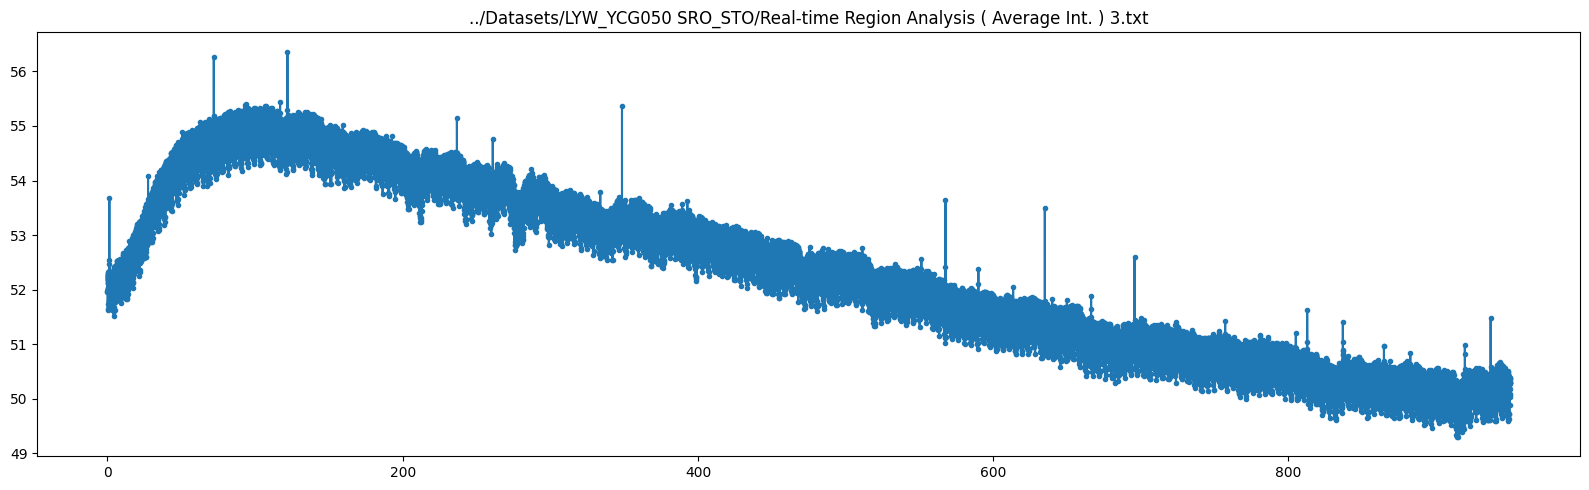

In [54]:
file = '../Datasets/LYW_YCG050 SRO_STO/Real-time Region Analysis ( Average Int. ) 3.txt'
data = np.loadtxt(file)
print(data.shape)
data = select_range(data, 50, 1000, y_col=2)
x = data[:,0]
y = data[:,1]
x = x - x[0]
data = np.column_stack((x, y))

plt.subplots(1, 1, figsize=(16,5))
plt.plot(data[:,0], data[:,1], marker='o', markersize=3)
plt.title(file)
plt.tight_layout()
plt.show()

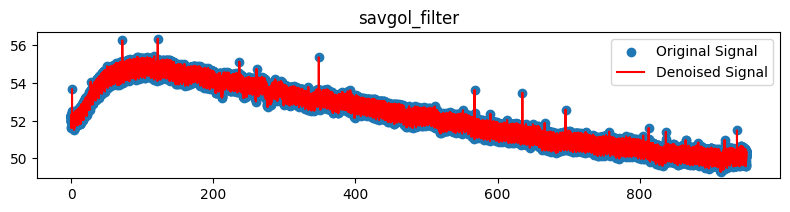

(46608,) (46608,)


In [55]:
expo_time = 20
camera_freq = 1000/expo_time
laser_freq = 5
denoise_params = {'savgol_window_order': (3, 2), 'pca_component': None, 'fft_cutoff_order':None, 'median_kernel_size':None}
viz_params = {'viz_denoise': True, 'viz_curves': True, 'viz_fittings': True, 'viz_ab': False}

if isinstance(data, str):
    data = np.loadtxt(data)
sample_x, sample_y = data[:,0], data[:,1]

# denoise
sample_x, sample_y = process_rheed_data(sample_x, sample_y, camera_freq, denoise_params, viz_params['viz_denoise'])  
print(sample_x.shape, sample_y.shape)    

6
x_peaks: [    9    19    29 ... 46588 46597 46603]
x_peaks shape: (4717,),  curve_y shape: (46608,), dist: 6, len(curve_y)-dist: 46602
4715 4715 4716


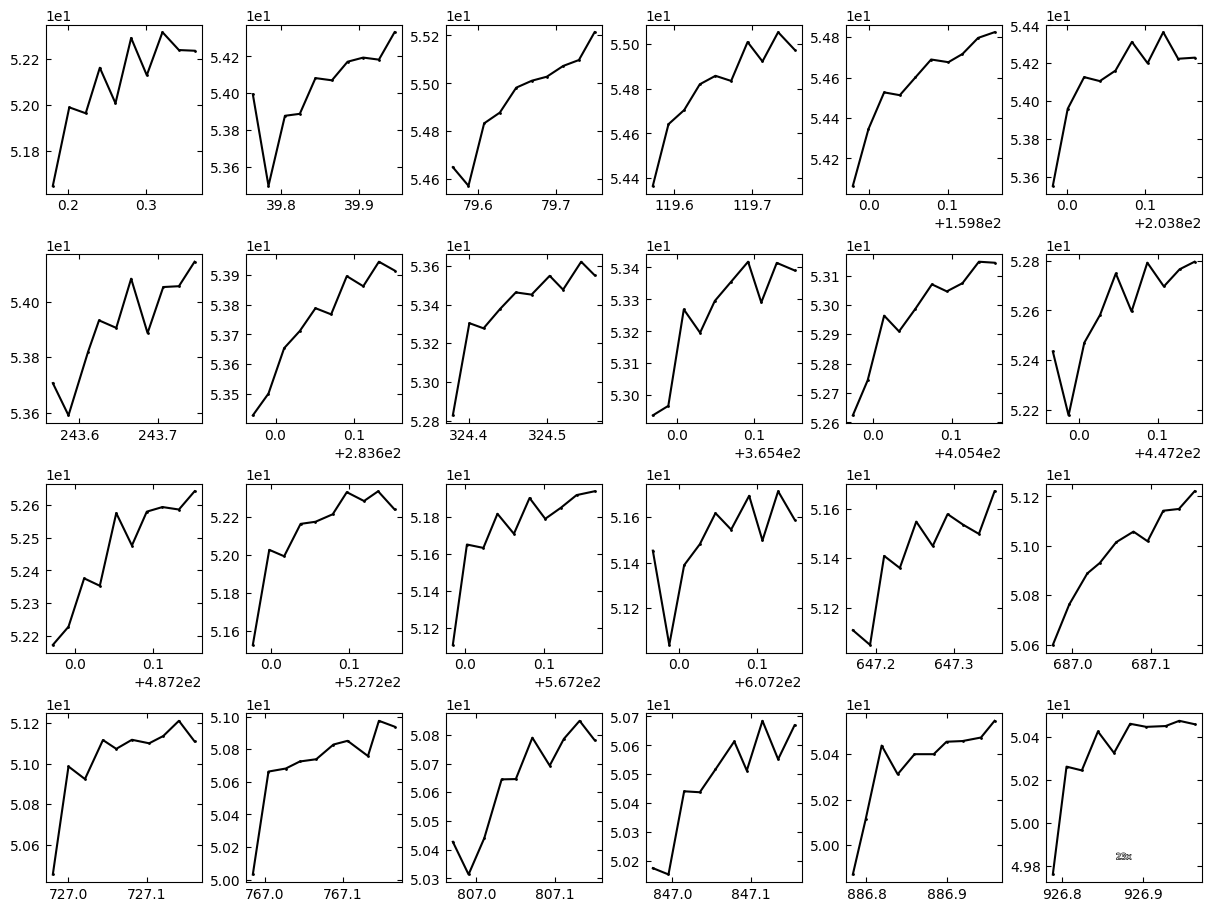

In [57]:
curve_params = {'trim_first':0, 'tune_tail':False, 'convolve_step':2, 'prominence':0.0001, 'mode':'same', 'linear_ratio':0}
dist = int(camera_freq/laser_freq*0.6)
print(dist)
# detect peaks
# print(sample_y[0].shape, sample_y[1].shape)
x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=laser_freq, curve_params=curve_params, debug=False)
print(len(xs), len(ys), len(x_peaks))  
# viz curves
if viz_params['viz_curves']:
    xs_sample, ys_sample = xs[::200], ys[::200]
    fig, axes = layout_fig(len(ys_sample), mod=6, figsize=(12,2*len(ys_sample)//6+1), layout='compressed')
    Viz.show_grid_plots(axes, xs_sample, ys_sample, labels=None, xlabel=None, ylabel=None, ylim=None, legend=None, color=None)

c:\Users\yig319\Anaconda3\envs\m3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


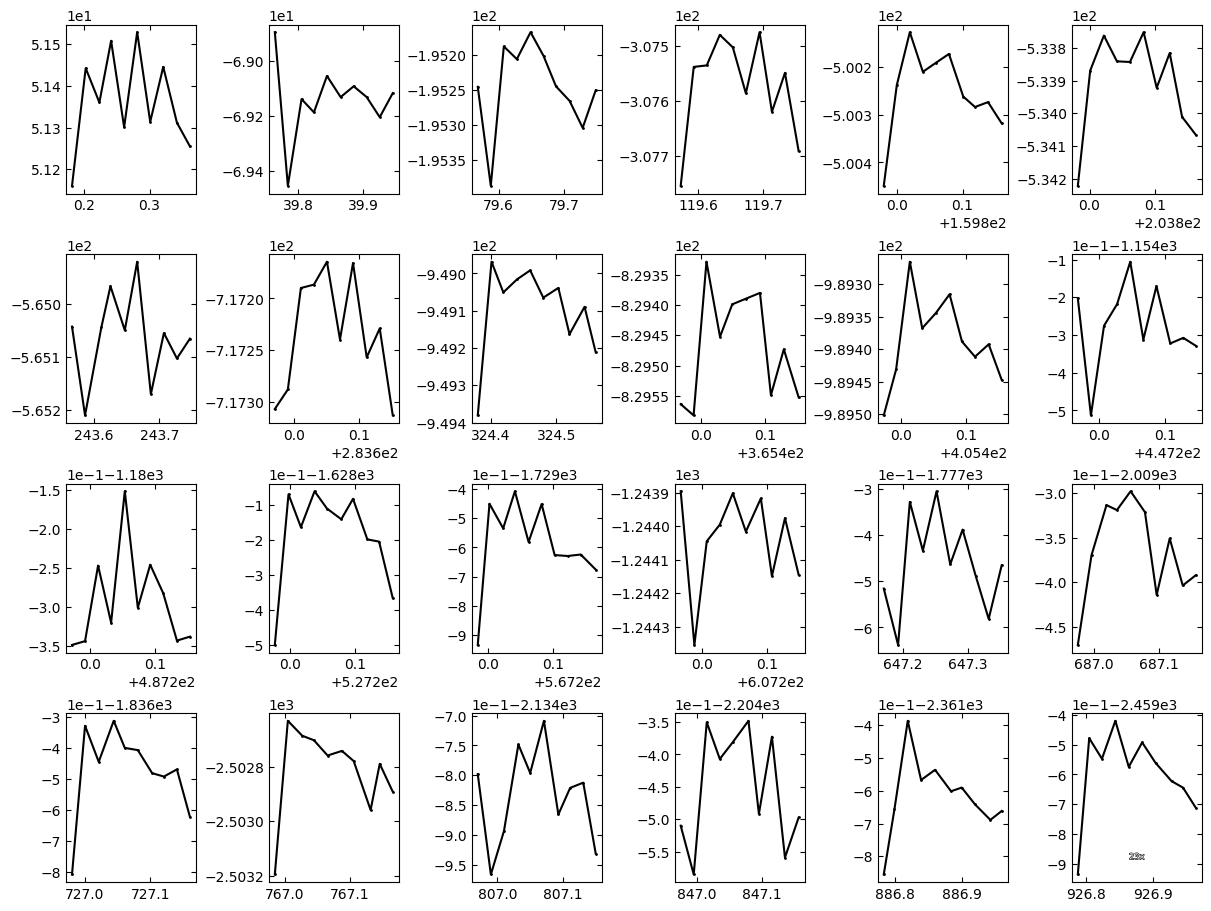

In [59]:
# denoise
xs, ys = process_curves(xs, ys, curve_params)     

# viz curves
if viz_params['viz_curves']:
    xs_sample, ys_sample = xs[::200], ys[::200]
    fig, axes = layout_fig(len(ys_sample), mod=6, figsize=(12, 2*len(ys_sample)//6+1), layout='compressed')
    Viz.show_grid_plots(axes, xs_sample, ys_sample, labels=None, xlabel=None, ylabel=None, ylim=None, legend=None, color=None)

In [60]:
fit_settings = {'I_diff': None, 'unify': True, 'bounds': [0.01, 1], 'p_init': (1, 0.1, 0.4), 'n_std': 1}
growth_name='YG050'


I_diff = fit_settings['I_diff']
unify = fit_settings['unify']

# Step 1: Normalize and extract amplitude
ys_nor, I_starts, I_ends = normalize_and_extract_amplitude(xs, ys, I_diff, unify)

# Step 2: Fit curves
parameters, ys_nor_fit, ys_nor_fit_failed, labels, losses = fit_curves(xs, ys_nor, fit_settings, growth_name)

# Step 3: De-normalize and assemble results
ys_fit = de_normalize_and_assemble(xs, ys, ys_nor_fit, I_starts, I_ends, I_diff, unify)

parameters = np.array(parameters)
metadata = [xs, ys, ys_fit, ys_nor, ys_nor_fit, ys_nor_fit_failed, labels, losses]

# parameters, metadata = fit_exp_function(xs, ys, growth_name='YG049', fit_settings=fit_settings)
a, b, tau = parameters[:,0], parameters[:,1], parameters[:,2]
[xs, ys, ys_fit, ys_nor, ys_nor_fit, ys_nor_fit_failed, labels, losses] = metadata
x_coors = x_peaks[:-1]

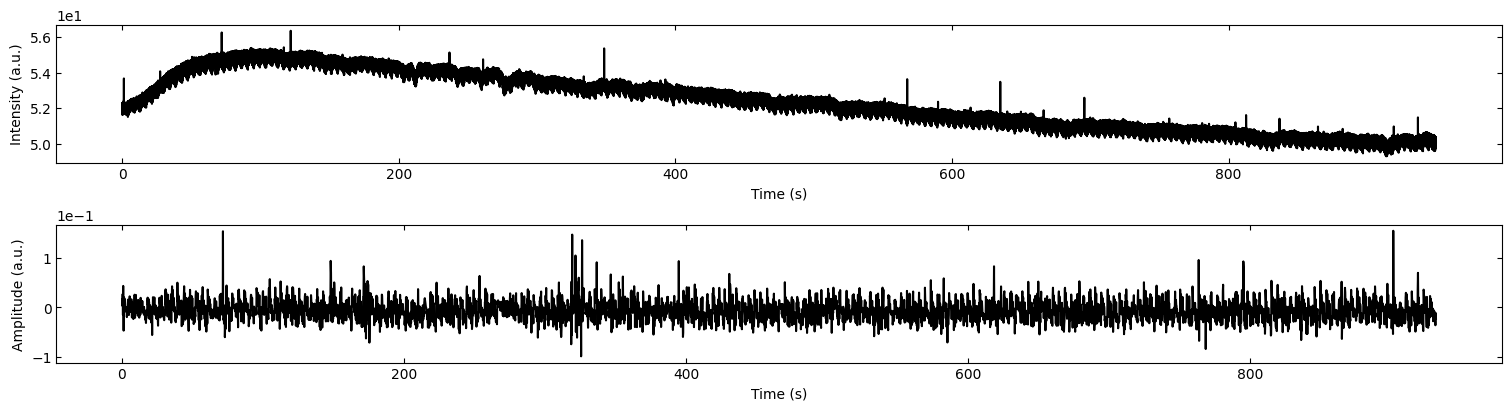

In [61]:
I_starts, I_ends = np.array(I_starts), np.array(I_ends)
I_diff = I_ends - I_starts

fig, axes = layout_fig(2, 1, figsize=(15, 2*2))
Viz.plot_curve(axes[0], sample_x, sample_y, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity (a.u.)', yaxis_style='sci')
Viz.plot_curve(axes[1], x_coors, I_diff, plot_type='lineplot', xlabel='Time (s)', ylabel='Amplitude (a.u.)', yaxis_style='sci')
plt.show()

In [97]:
import numpy as np
from scipy.signal import find_peaks

def find_data_peaks(x, y, height=None, distance=None, prominence=None):
    """
    Detects peaks in 1D data.

    Args:
        x (numpy.array): The x-values of the data.
        y (numpy.array): The y-values of the data.
        height (float, optional): Minimum height of peaks.
        distance (int, optional): Minimum number of samples between successive peaks.
        prominence (float, optional): Minimum prominence of the peaks.

    Returns:
        numpy.array: x-values of the detected peaks.
        numpy.array: y-values of the detected peaks.
    """
    # Finding peaks
    peaks, _ = find_peaks(y, height=height, distance=distance, prominence=prominence)
    
    # Extracting the peak x and y values
    peak_x = x[peaks]
    peak_y = y[peaks]

    return peak_x, peak_y

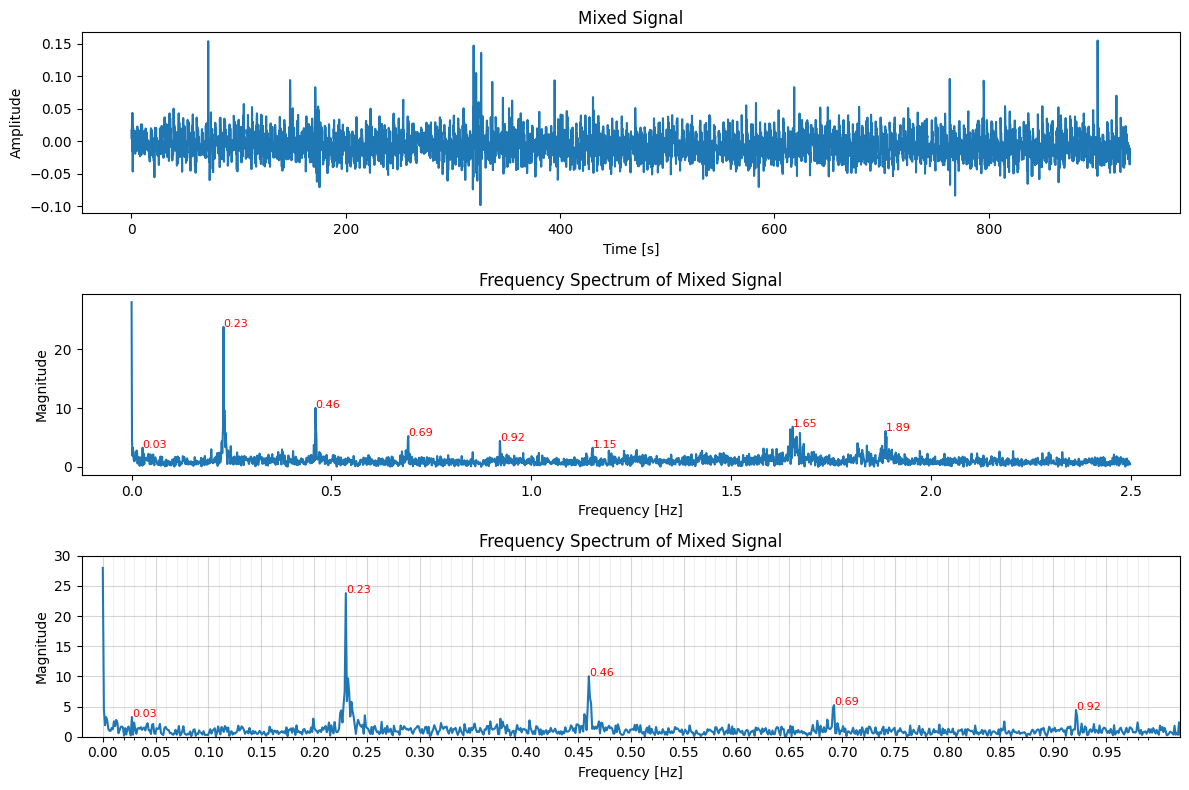

In [101]:
# Generate synthetic mixed signals
fs = 5  # Sampling frequency

t = x_coors
mixed_signal = I_diff

# Perform FFT
n = len(t)
f = np.fft.fftfreq(n, 1/fs)
mixed_signal_fft = fft(mixed_signal)

x_fft, y_fft = f[:n//2], np.abs(mixed_signal_fft)[:n//2]

x_peaks, y_peaks = find_data_peaks(x_fft, y_fft, height=1, distance=100, prominence=3)

# Plot the mixed signal and its frequency spectrum
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
axes[0].plot(t, mixed_signal)
axes[0].set_title('Mixed Signal')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Amplitude')


axes[1].plot(x_fft, y_fft)
axes[1].set_title('Frequency Spectrum of Mixed Signal')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('Magnitude')
for x, y in zip(x_peaks, y_peaks):
    axes[1].text(x, y, f'{x:.2f}', fontsize=8, color='red')

axes[2].plot(x_fft, y_fft)
axes[2].set_title('Frequency Spectrum of Mixed Signal')
axes[2].set_xlabel('Frequency [Hz]')
axes[2].set_ylabel('Magnitude')

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1, 0.05)
minor_ticks = np.arange(0, 1, 0.01)
axes[2].set_xticks(major_ticks)
axes[2].set_xticks(minor_ticks, minor=True)
axes[2].grid(which='minor', alpha=0.2)
axes[2].grid(which='major', alpha=0.5)
axes[2].set_xlim(-0.02, 1.02)
axes[2].set_ylim(0, 30)

for x, y in zip(x_peaks, y_peaks):
    if x < 1.02:
        axes[2].text(x, y, f'{x:.2f}', fontsize=8, color='red')

plt.tight_layout()
plt.show()

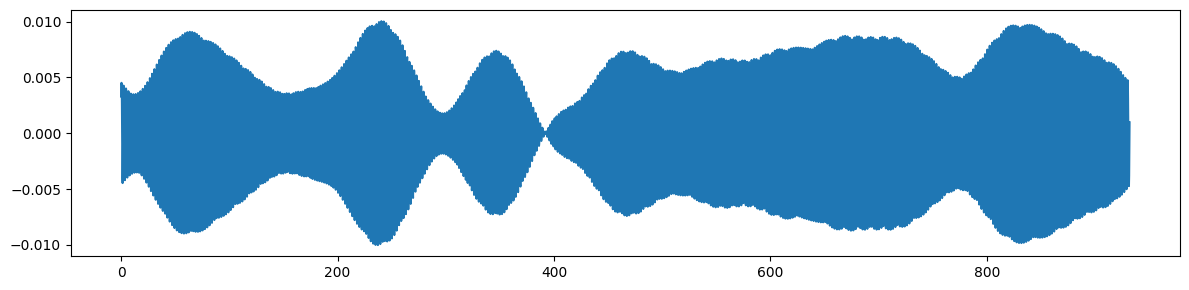

In [103]:
# Isolate each frequency component
filtered_signal = bandpass_filter(mixed_signal_fft, f, fs, 0.22, 0.24)

# Plot isolated signals
plt.figure(figsize=(12, 3))
plt.plot(t, filtered_signal.real)
plt.tight_layout()
plt.show()

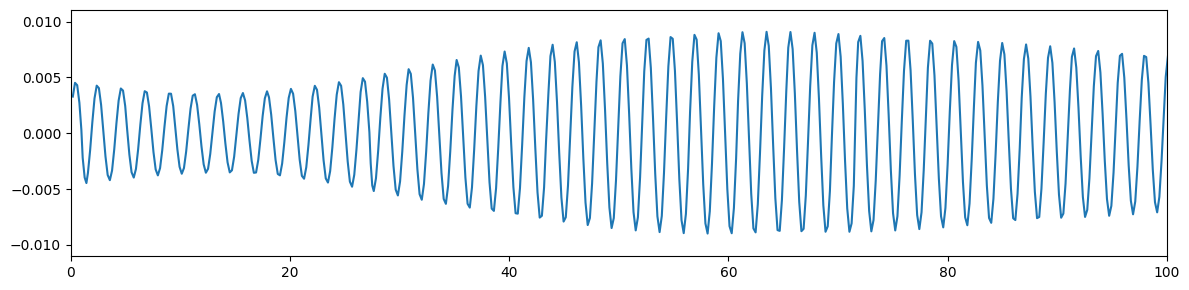

In [104]:
# Plot isolated signals
plt.figure(figsize=(12, 3))
plt.plot(t, filtered_signal.real)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

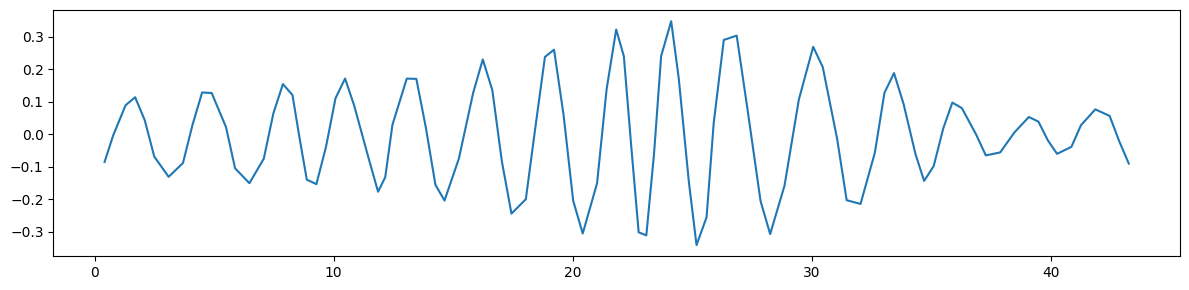

In [11]:
# Isolate each frequency component
filtered_signal = bandpass_filter(mixed_signal_fft, f, fs, 0.65, 0.85)

# Plot isolated signals
plt.figure(figsize=(12, 3))
plt.plot(t, filtered_signal.real)
plt.tight_layout()
plt.show()

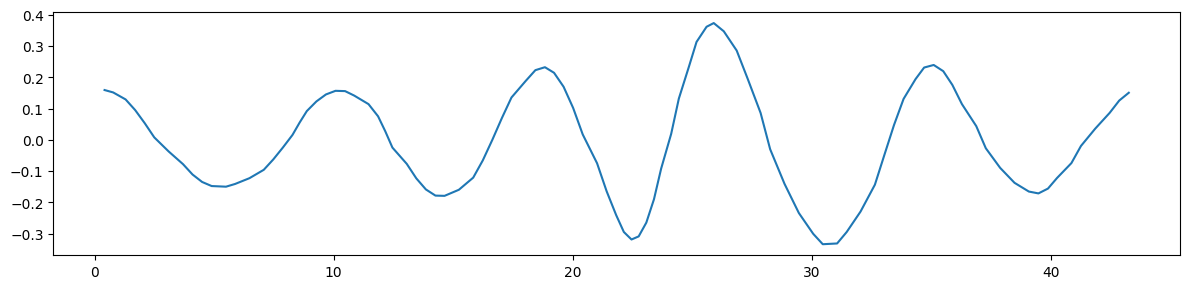

In [9]:
# Isolate each frequency component
filtered_signal = bandpass_filter(mixed_signal_fft, f, fs, 0.15, 0.35)

# Plot isolated signals
plt.figure(figsize=(12, 3))
plt.plot(t, filtered_signal.real)
plt.tight_layout()
plt.show()

In [7]:
print(sample_x.shape, sample_y.shape, x_coors.shape, a.shape, b.shape, tau.shape)

(4960,) (4960,) (200,) (200,) (200,) (200,)


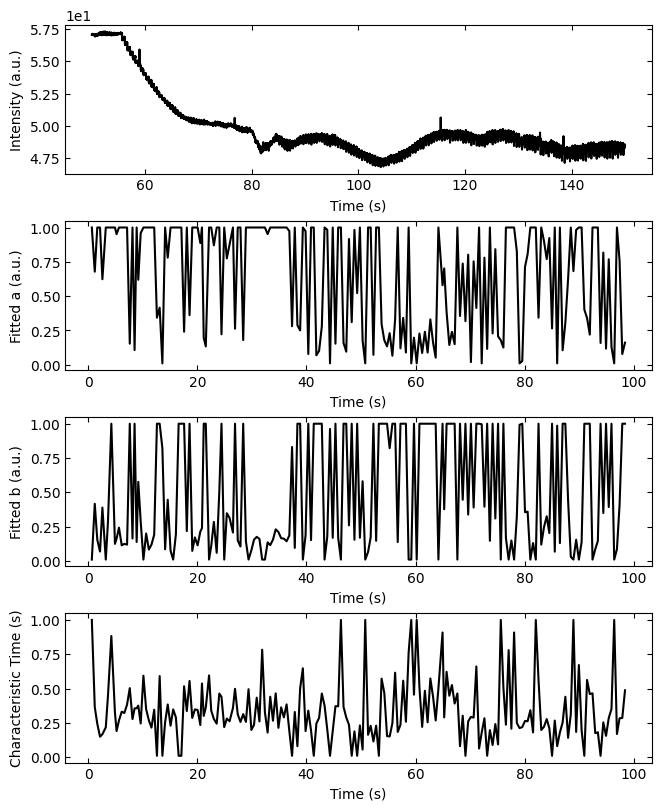

In [8]:
fig, axes = layout_fig(4, 1, figsize=(6.5, 2*4))
Viz.plot_curve(axes[0], sample_x, sample_y, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity (a.u.)', yaxis_style='sci')
Viz.plot_curve(axes[1], x_coors, a, plot_type='lineplot', xlabel='Time (s)', ylabel='Fitted a (a.u.)')
Viz.plot_curve(axes[2], x_coors, b, plot_type='lineplot', xlabel='Time (s)', ylabel='Fitted b (a.u.)')
Viz.plot_curve(axes[3], x_coors, tau, plot_type='lineplot', xlabel='Time (s)', ylabel='Characteristic Time (s)')
plt.show()